In [8]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

--------------------------------<br>
Set input data file name(s)<br>
--------------------------------

In [9]:
fname = "./data/data_2021080100/gdas.t00z.adpupa.tm00_nc002001.nc"
print("Praveen checking fname = ", fname)

Praveen checking fname =  ./data/data_2021080100/gdas.t00z.adpupa.tm00_nc002001.nc


----------------------<br>
Read input data file<br>
----------------------

In [10]:
ncd = nc.Dataset(fname, 'r')

--------------------------<br>
NetCDF global attributes<br>
--------------------------

In [11]:
nc_attrs = ncd.ncattrs()
print('NetCDF Global Attributes: ')
print('nc_attrs = ', nc_attrs)
for nc_attr in nc_attrs:
    print('nc_attr:', ncd.getncattr(nc_attr))

NetCDF Global Attributes: 
nc_attrs =  ['_ioda_layout', '_ioda_layout_version']
nc_attr: ObsGroup
nc_attr: 0


------------------------<br>
Dimension information<br>
------------------------

In [12]:
nc_dims = [dim for dim in ncd.dimensions]  # list of nc dimensions
print('nc_dims = ', nc_dims)
for dim in nc_dims:
    print(f'nc_dims {dim} length = {len(ncd.dimensions[dim])}')

nc_dims =  ['Location']
nc_dims Location length = 169320


---------------------<br>
Variable information<br>
---------------------

In [13]:
lat = ncd.groups['MetaData'].variables['latitude'][:].ravel()
lon = ncd.groups['MetaData'].variables['longitude'][:].ravel()
dateTime = ncd.groups['MetaData'].variables['dateTime'][:].ravel()
stationElevation = ncd.groups['MetaData'].variables['stationElevation'][:].ravel()
stationIdentification = ncd.groups['MetaData'].variables['stationIdentification'][:].ravel()
pressure = ncd.groups['MetaData'].variables['pressure'][:].ravel()
airTemperature = ncd.groups['ObsValue'].variables['airTemperature'][:].ravel()
dewpointTemperature = ncd.groups['ObsValue'].variables['dewpointTemperature'][:].ravel()
windSpeed = ncd.groups['ObsValue'].variables['windSpeed'][:].ravel()
windDirection = ncd.groups['ObsValue'].variables['windDirection'][:].ravel()

--------------------------------------<br>
Create DataFrame with lat, lon, pressure<br>
--------------------------------------

In [14]:
data = pd.DataFrame({
    'latitude': lat,
    'longitude': lon,
    'dateTime': dateTime,
    'stationElevation': stationElevation,
    'stationIdentification': stationIdentification,
    'pressure': pressure,
    'airTemperature': airTemperature,
    'dewpointTemperature': dewpointTemperature,
    'windSpeed': windSpeed,
    'windDirection': windDirection
})

---------------------------<br>
Statistical Analysis<br>
---------------------------<br>
Descriptive statistics

In [15]:
print("\nDescriptive Statistics:\n", data.describe())


Descriptive Statistics:
             latitude      longitude      dateTime  stationElevation  \
count  169320.000000  169320.000000  1.693200e+05      169320.00000   
mean       31.269894      43.563778  1.627775e+09         399.77259   
std        26.948259      89.460495  1.592163e+03         684.12444   
min       -90.000000    -170.710007  1.627769e+09         -22.00000   
25%        23.350000     -19.565001  1.627776e+09          20.00000   
50%        36.419998      79.165001  1.627776e+09         105.00000   
75%        49.227501     115.000000  1.627776e+09         417.50000   
max        82.500000     179.220001  1.627780e+09        4508.00000   

            pressure  airTemperature  dewpointTemperature     windSpeed  \
count   64839.000000    45581.000000         37543.000000  52341.000000   
mean    32273.690063      242.961624           234.132416     12.030702   
std     30223.416463       30.216349            35.068127      9.348969   
min        30.000000      183.4499

Count missing values

In [16]:
missing_values_count = data.isnull().sum()
print("\nMissing Values Count:\n", missing_values_count)


Missing Values Count:
 latitude                      0
longitude                     0
dateTime                      0
stationElevation              0
stationIdentification         0
pressure                 104481
airTemperature           123739
dewpointTemperature      131777
windSpeed                116979
windDirection            116979
dtype: int64


---------------------------<br>
Replace Missing Values by Mean<br>
---------------------------<br>
If pressure has missing values, fill them with the mean of the column

In [23]:
data['pressure'].fillna(data['pressure'].mean(), inplace=True)

Recheck if there are still any missing values

In [24]:
missing_values_count_after_imputation = data.isnull().sum()
print("\nMissing Values Count After Imputation:\n", missing_values_count_after_imputation)


Missing Values Count After Imputation:
 latitude                      0
longitude                     0
dateTime                      0
stationElevation              0
stationIdentification         0
pressure                      0
airTemperature           123739
dewpointTemperature      131777
windSpeed                116979
windDirection            116979
dtype: int64


---------------------------<br>
Random Forest for Pressure Prediction<br>
---------------------------<br>
Features and target

In [25]:
X = data[['latitude', 'longitude']]  # Features (lat, lon)
y = data['pressure']  # Target (pressure)

Split data into training and testing sets

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Initialize RandomForestRegressor

In [27]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

Train the model

In [28]:
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Make predictions

In [29]:
y_pred = rf.predict(X_test)

Evaluate the model

In [30]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [31]:
print(f"\nMean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 342973198.74102765
R-squared: 0.016265432609447572


---------------------------<br>
Plotting the Results<br>
---------------------------

Plot 1: Pressure vs Latitude and Longitude (scatter plot)

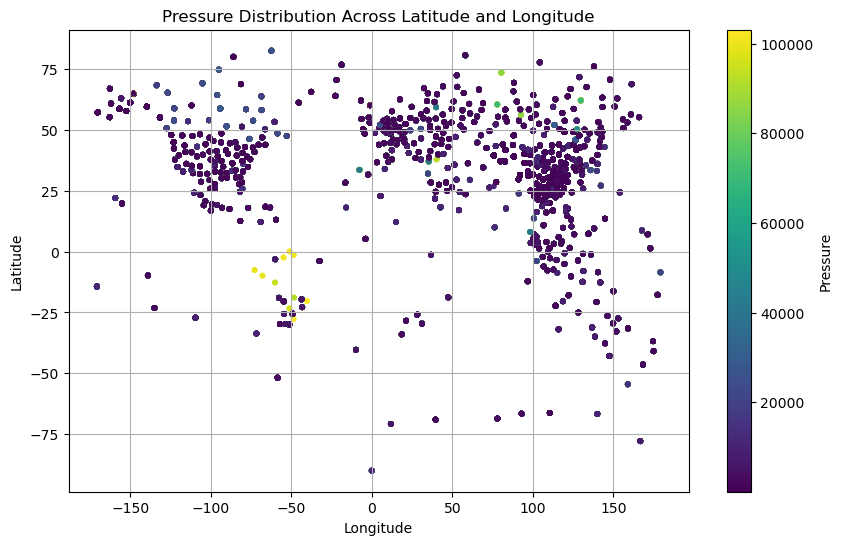

In [32]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(lon, lat, c=pressure, cmap='viridis', marker='o', s=10)
plt.colorbar(scatter, label='Pressure')
plt.title('Pressure Distribution Across Latitude and Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.savefig('pressure_distribution.png')
plt.show()

Plot 2: Actual vs Predicted Pressure (Scatter plot)

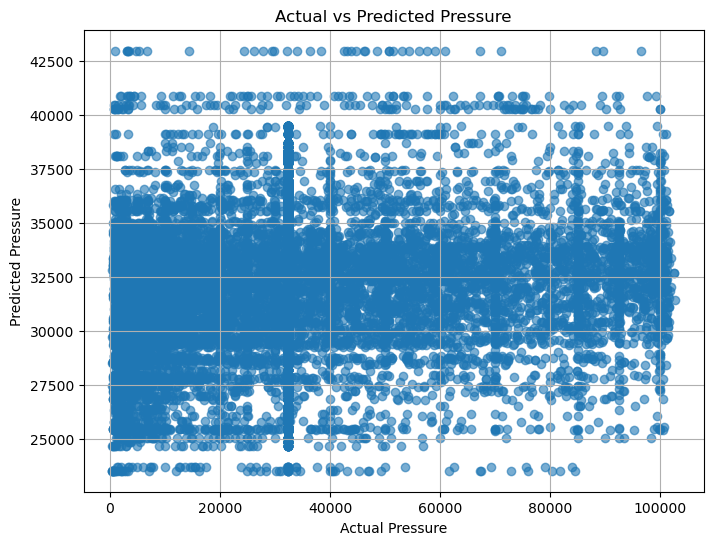

In [33]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
#plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Actual vs Predicted Pressure')
plt.xlabel('Actual Pressure')
plt.ylabel('Predicted Pressure')
plt.grid(True)
plt.savefig('actual_vs_predicted_pressure.png')
plt.show()

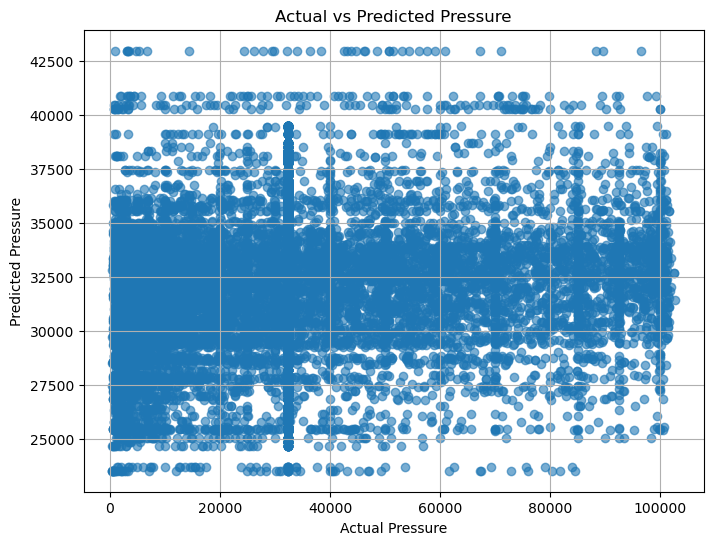

In [34]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
#plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Actual vs Predicted Pressure')
plt.xlabel('Actual Pressure')
plt.ylabel('Predicted Pressure')
plt.grid(True)
plt.savefig('actual_vs_predicted_pressure.png')
plt.show()

Exit after completing all tasks

In [ ]:
exit()